In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Estimator

In [3]:
class Estimator:
    def __init__(self,bins=None,lam=None):
        self.bins = bins
        self.lam = lam

    def set_bins_params(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        self.val_min = val_min
        self.width = width

    def fit(self,val,residual,p):
        self.set_bins_params(val)
        index = self.get_index(val)

        residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))
        
        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin
        
        grads = self.get_grads(index)

        return grads


    def get_index(self,val):
        index = ((val - self.val_min)//self.width).astype('int32') if self.width !=0 else np.zeros(val.shape[0])
        index = np.where(index >= self.bins,self.bins-1,index)
        index = np.where(index < 0,0,index)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Decision Tree Estimator

In [4]:
class Estimator_DC:
    def __init__(self,max_depth=None,lam=None):
        self.max_depth = max_depth
        self.lam = lam

    def set_grads_bin(self,residual,p):
        residual_bin = np.stack([np.sum(residual[self.index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[self.index==i],1-p[self.index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))

        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin

        return self.get_grads(self.index)

    def fit(self,val,y):
        val = val.reshape(-1,1)

        self.clf = DecisionTreeClassifier(max_depth=self.max_depth)
        self.clf.fit(val,y)
        self.index = self.get_index(val)
        
        self.bins = len(self.clf.tree_.threshold)

    # def get_loss(self,base_gini):
    #     self.loss = -(base_gini - np.sum(self.clf.tree_.impurity))

    #     return self.loss

    def get_loss(self):
        self.loss = self.clf.tree_.impurity@(self.clf.tree_.n_node_samples/sum(self.clf.tree_.n_node_samples))
        return self.loss

    # def get_loss(self,grads,log_odds,p,learning_rate):
        # log_odds_1 = log_odds + learning_rate * grads
        
        # p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
        # p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
        
        # self.loss = np.sum(np.power(self.Y - p_1,2))
        # self.loss = -np.sum(np.power(self.p - p_1,2))
        # self.loss = -np.sum(np.abs(grads))
    #     return self.loss

    def get_index(self,val):
        val = val.reshape(-1,1)
        index = self.clf.apply(val)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Node

In [5]:
class Node:
    def __init__(self,terminal,func=None,sons=None,index=None,fit=None,estimator=None):
        self.terminal = terminal
        self.sons = sons
        self.func = func
        self.index = index
        self.fitness = fit
        self.estimator = estimator
        if self.terminal:
            self.depth = 0
            self.numNode = 1
        else:
            self.depth = max([s.depth for s in sons]) + 1
            self.numNode = sum([s.numNode for s in sons])+ 1

    def predict_grad(self,X):
        val = self.predict_val(X)
        return self.estimator.predict_grad(val)
        
    def predict_val(self,X):
        X = X.astype('float64')
        return self.pred_rec(X.T)
    def pred_rec(self,X):
        if not self.terminal:
            return self.func([s.pred_rec(X) for s in self.sons])
        else:
            return X[self.index]
    def __str__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string
    def __repr__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string

# Engine

In [6]:
class Engine:
    def __init__(self,opset,X,Y,Y_one_hot,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y
        self.Y_one_hot = Y_one_hot

        base_gini = (pd.value_counts(y_train)/y_train.shape)
        self.base_gini = sum(base_gini*(1-base_gini))

        self.log_odds = log_odds
        self.p = p
        self.residual = Y_one_hot - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    # def calculate_grad(self,val,lam):
    #     bins = self.bins
    #     val_max = np.max(val)
    #     val_min = np.min(val)
    #     width = ((val_max - val_min)/bins)

    #     index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
    #     index = np.where(index >= bins,bins-1,index)
    #     index = np.where(index < 0,0,index)

    #     residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
    #     p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)]) + lam
    #     grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    #     grads = np.zeros(self.log_odds.shape)
    #     for i in range(bins):
    #         grads[index==i] = grad_bin[i]
            
    #     return grads

    
    def calculate_fitness(self,vals,lam=0,max_depth=3):
        fitness = []
        estimators = []
        for val in vals:
            # est = Estimator(self.bins,lam)
            # grads = est.fit(val,self.residual,self.p)
            est = Estimator_DC(max_depth,lam)
            est.fit(val,self.Y)

            # grads = est.set_grads_bin(self.residual,self.p)
            # loss = est.get_loss(grads,self.log_odds,self.p,self.learning_rate)

            # loss = est.get_loss(self.base_gini)
            
            loss = est.get_loss()
            
            fitness.append(loss)
            estimators.append(est)

        return fitness,estimators
    

    def evolve(self,total_size,batch_size,elite_size,lam=0,max_depth=3,verbose=0):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        elites_estimator = []

        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,estimators = self.calculate_fitness(vals,lam,max_depth)
            # fitness = self.calculate_decision(vals,1,lam)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)
            elites_estimator.extend(estimators)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]
            elites_estimator = [elites_estimator[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index],
                estimator=elites_estimator[index]
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict_val(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

# Stack

In [7]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [8]:
def adding_unique_node(stack,losses,new_nodes,tolerance):
    protect_losses = [-np.inf] + losses + [np.inf]
    protect_stack = [None] + stack + [None]
    new_losses = [ node.estimator.loss for node in new_nodes]

    for i in range(len(new_losses)):
        new_loss = new_losses[i]
        new_node = new_nodes[i]
        
        index = np.searchsorted(protect_losses,new_loss,side='left')
        left_index = index - 1
        right_index = index 

        left_diff = new_loss - protect_losses[left_index]
        left_node = protect_stack[left_index]

        right_diff = protect_losses[right_index] - new_loss
        right_node = protect_stack[right_index]

        mid_flag,left_flag,right_flag = (1,1,1)

        if left_diff < tolerance:
            if left_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                left_flag = 0
        if right_diff < tolerance:
            if right_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                right_flag = 0
        
        if mid_flag == 1:
            if right_flag == 0:
                protect_stack.pop(right_index)
                protect_losses.pop(right_index)
                
            protect_stack.insert(index,new_node)
            protect_losses.insert(index,new_loss)

            if left_flag == 0:
                protect_stack.pop(left_index)
                protect_losses.pop(left_index)
    
    losses = protect_losses[1:-1]
    stack = protect_stack[1:-1]

    return stack,losses

In [9]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# connect-4

In [10]:
df = pd.read_csv("../data/connect-4.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [62]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

learning_rate = 0.3
lam = 1
max_depth = 5
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]

In [66]:
tolerance = min([losses[i] - losses[i-1] for i in range(1,len(losses))])/10
# tolerance = 0.000001
i = 0

epoch = 5

total = 10
elite = 3


while len(stack) < 20000:
        eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
        for j in range(epoch):
                eg.evolve(total,total,elite,lam,max_depth,0)
        # s.extend([eg.best[1]])
        newcomers = eg.nodes[-elite*epoch:]
        stack,losses = adding_unique_node(stack,losses,newcomers,tolerance)

        print(i,len(stack),sum([n.numNode for n in stack]))
        i += 1

0 3798 17714
1 3805 17747
2 3811 17775
3 3816 17792
4 3821 17815
5 3830 17868
6 3835 17887
7 3838 17900
8 3846 17942
9 3852 17966
10 3855 17979
11 3865 18023
12 3869 18041
13 3872 18056
14 3877 18087
15 3886 18126
16 3892 18156
17 3897 18181
18 3902 18204
19 3906 18220
20 3912 18252
21 3918 18282
22 3926 18316
23 3932 18342
24 3939 18373
25 3944 18392
26 3953 18427
27 3959 18455
28 3968 18490
29 3974 18514
30 3980 18538
31 3986 18568
32 3993 18597
33 4001 18641
34 4007 18667
35 4015 18711
36 4022 18738
37 4027 18757
38 4032 18778
39 4035 18801
40 4040 18822
41 4046 18850
42 4051 18871
43 4058 18906
44 4065 18935
45 4074 18968
46 4077 18983
47 4083 19011
48 4089 19049
49 4093 19067
50 4098 19094
51 4102 19114
52 4105 19125
53 4110 19154
54 4114 19172
55 4120 19196
56 4127 19225
57 4132 19248
58 4137 19275
59 4141 19299
60 4145 19325
61 4150 19350
62 4155 19377
63 4158 19394
64 4165 19431
65 4168 19446
66 4174 19476
67 4179 19497
68 4183 19523
69 4186 19532
70 4193 19559
71 4194 19564
72

KeyboardInterrupt: 

array([0.45878378, 0.45882653, 0.45886928, ..., 0.50144754, 0.50149029,
       0.50153304])

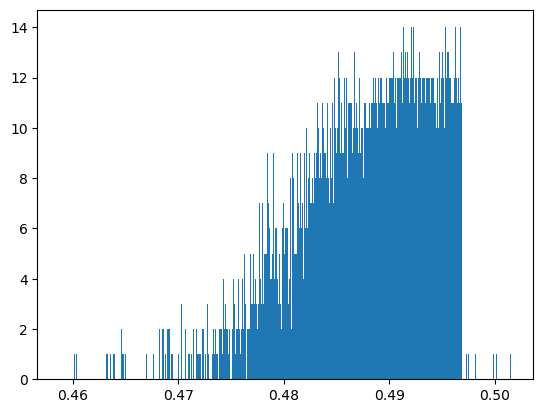

In [43]:
plt.hist(losses,bins=1000)[1]

In [67]:
import warnings
warnings.filterwarnings("ignore")

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

lam = 10
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []


train_sse = []
test_sse = []

counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
    print(train_sse[-1],test_sse[-1],i+1,len(a))


    pred = np.argmax(p,axis=1)
    train_acc.append(f1_score(pred,y_train,average='macro'))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(f1_score(test_pred,y_test,average='macro'))


    # pred = np.argmax(p,axis=1)
    # train_acc.append(accuracy_score(pred,y_train))
    # test_pred = np.argmax(test_p,axis=1)
    # test_acc.append(accuracy_score(test_pred,y_test))

    print('\t',train_acc[-1],test_acc[-1],i+1,len(a))
    

21177.328847251236 21207.9089138542 1 6700
	 0.6582983006690746 0.6583084164717724 1 6700
18550.79087958562 18611.04661928712 2 6700
	 0.6582983006690746 0.6583084164717724 2 6700
17301.129622845165 17372.371774351166 3 6700
	 0.6582983006690746 0.6583084164717724 3 6700
16657.879680081198 16735.763674069483 4 6700
	 0.6582983006690746 0.6583084164717724 4 6700
16328.897807677618 16409.731244300994 5 6700
	 0.6582983006690746 0.6583084164717724 5 6700
16162.26380313372 16245.119272168837 6 6700
	 0.6582983006690746 0.6583084164717724 6 6700
16070.456103481722 16158.506399485565 7 6700
	 0.6582983006690746 0.6583084164717724 7 6700
16025.955561869272 16116.32071229328 8 6700
	 0.6582983006690746 0.6583084164717724 8 6700
16000.76274772821 16090.483050093986 9 6700
	 0.6582983006690746 0.6583084164717724 9 6700
15973.90231033752 16065.847796920785 10 6700
	 0.6582983006690746 0.6583084164717724 10 6700
15966.18143801187 16057.66499267869 11 6700
	 0.6582983006690746 0.6583084164717724 11

In [80]:
i = -1

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

32449 0.8659186452720706 0.8265786435359247


In [81]:
i = 5000

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

25814 0.857362780508023 0.8236478285325202


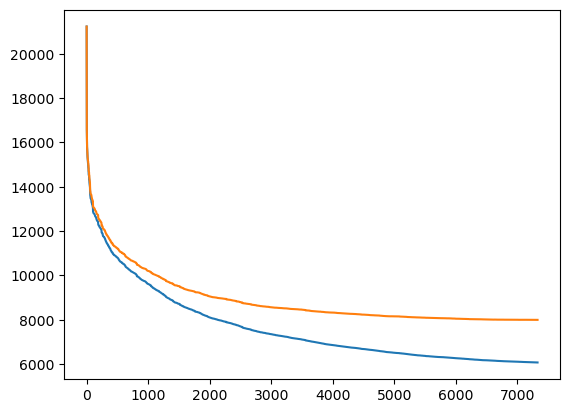

In [48]:
plt.plot(train_sse)
plt.plot(test_sse)

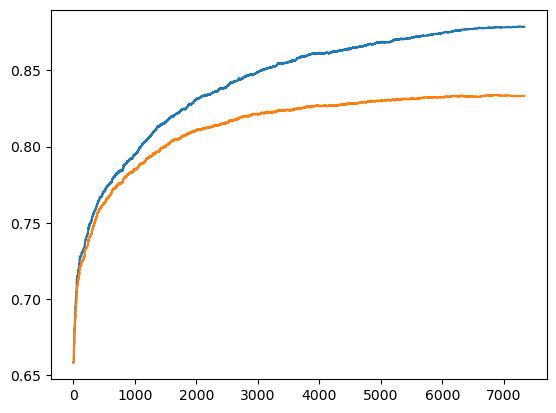

In [49]:
plt.plot(train_acc)
plt.plot(test_acc)

In [30]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

# pred = xgb.predict_proba(X_train)
# pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

# pred = xgb.predict_proba(X_test)
# pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0      0.808     0.274     0.409      3225
           1      0.827     0.829     0.828      8317
           2      0.881     0.965     0.921     22236

    accuracy                          0.866     33778
   macro avg      0.839     0.689     0.719     33778
weighted avg      0.861     0.866     0.849     33778

              precision    recall  f1-score   support

           0      0.516     0.141     0.221      3224
           1      0.773     0.755     0.764      8318
           2      0.851     0.948     0.897     22237

    accuracy                          0.823     33779
   macro avg      0.713     0.614     0.627     33779
weighted avg      0.799     0.823     0.799     33779



(300, 6.0, 28186)